In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


def get_data_split(data_df, selected_columns, target_label):
    df_processed = data_df[selected_columns].reset_index(drop=True)
    input_feat = list(set(selected_columns).difference({target_label}))

    df_x = df_processed[input_feat].reset_index(drop=True)
    df_y = df_processed[target_label]

    transfer = MinMaxScaler(feature_range=(0, 1))

    # normalization
    df_x = transfer.fit_transform(df_x)

    return train_test_split(df_x, df_y, test_size=0.2, random_state=42)

In [3]:
import pandas as pd
import numpy as np

sun_data_df = pd.read_csv('dataset_processed.csv')

df_with_location_en = pd.get_dummies(sun_data_df, columns=['Location'], drop_first=True)
df_with_loc_season_en = pd.get_dummies(df_with_location_en, columns=['Season'], drop_first=True)

# Only data between 10 a.m. and 3 p.m. is available
# excluding periods when no power generation will occur
min_hour_of_interest = 10
max_hour_of_interest = 15

df_with_loc_season_en['delta_hr'] = df_with_loc_season_en.Hour - min_hour_of_interest

# There is a perfect correlation between the cosine of the date characteristic and its actual value (month and hour)
df_with_loc_season_en['sine_mon'] = np.sin((df_with_loc_season_en.Month - 1) * np.pi / 11)
df_with_loc_season_en['cos_mon'] = np.cos((df_with_loc_season_en.Month - 1) * np.pi / 11)

df_with_loc_season_en['sine_hr'] = np.sin(
    (df_with_loc_season_en.delta_hr * np.pi / (max_hour_of_interest - min_hour_of_interest)))
df_with_loc_season_en['cos_hr'] = np.cos(
    (df_with_loc_season_en.delta_hr * np.pi / (max_hour_of_interest - min_hour_of_interest)))

selected_columns = ['Latitude', 'Humidity', 'Temp', 'power_class', 'Wind',
                    'Visibility', 'Pressure', 'Cloud', 'Location_Grissom',
                    'Location_Hill Weber', 'Location_JDMT', 'Location_Kahului',
                    'Location_MNANG', 'Location_Malmstrom', 'Location_March AFB',
                    'Location_Offutt', 'Location_Peterson', 'Location_Travis',
                    'Location_USAFA', 'Season_Spring', 'Season_Summer', 'Season_Winter',
                    'sine_mon', 'cos_mon', 'sine_hr', 'cos_hr']

x_train, x_test, y_train, y_test = get_data_split(df_with_loc_season_en, selected_columns, 'power_class')

print(len(x_train), len(x_test))

16836 4209


In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6), n_estimators=200)
abc.fit(x_train, y_train)

print("accuracy:", abc.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(abc.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(abc.predict(x_test), y_test, average='weighted'))

accuracy: 0.4922784509384652
train f1_score: 0.6796057398258738
test f1_score: 0.4907561064522966


In [6]:
from sklearn.model_selection import GridSearchCV

estimatorCart = DecisionTreeClassifier(max_depth=6, min_samples_split=10, min_samples_leaf=5, random_state=24)

# Optimizing the number of weak learners for parameters
param_test1 = {"n_estimators": range(150, 300, 50)}

gsearch1 = GridSearchCV(estimator=AdaBoostClassifier(estimatorCart), param_grid=param_test1, scoring="roc_auc", cv=5)
gsearch1.fit(x_train, y_train)
print(gsearch1.best_params_)

/Users/chenxingyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/chenxingyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/chenxingyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/chenxingyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 352, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/chenxingyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test pa

{'n_estimators': 150}


In [7]:
# Continue to optimize the number of weak learners and search again within the range of the optimal number of learners
n_estimator1 = 150
param_test2 = {"n_estimators": range(n_estimator1 - 30, n_estimator1 + 30, 10)}
gsearch2 = GridSearchCV(estimator=AdaBoostClassifier(estimatorCart), param_grid=param_test2, scoring="roc_auc", cv=5)
gsearch2.fit(x_train, y_train)
print(gsearch2.best_params_)

/Users/chenxingyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/chenxingyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/chenxingyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/chenxingyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 352, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/Users/chenxingyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test pa

{'n_estimators': 120}


In [8]:
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6, random_state=24), n_estimators=120)
abc.fit(x_train, y_train)

print("accuracy:", abc.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(abc.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(abc.predict(x_test), y_test, average='weighted'))

accuracy: 0.4751722499406035
train f1_score: 0.6463512763256205
test f1_score: 0.47544808377474834


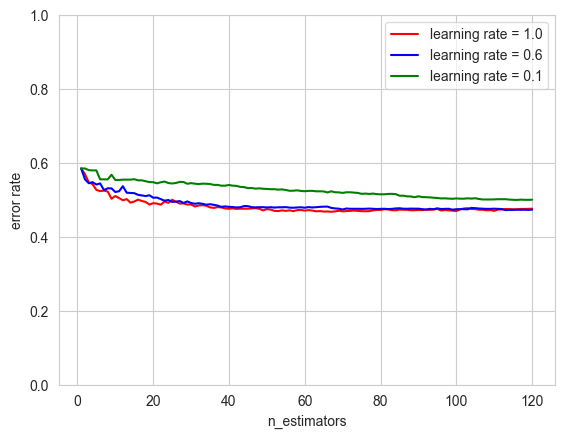

In [10]:
from sklearn.metrics import zero_one_loss
import matplotlib.pyplot as plt
import seaborn as sns

n_estimators = 120

estimatorCart = DecisionTreeClassifier(max_depth=1)
dt_stump1 = AdaBoostClassifier(base_estimator=estimatorCart, n_estimators=n_estimators, learning_rate=1.0)
dt_stump2 = AdaBoostClassifier(base_estimator=estimatorCart, n_estimators=n_estimators, learning_rate=0.6)
dt_stump3 = AdaBoostClassifier(base_estimator=estimatorCart, n_estimators=n_estimators, learning_rate=0.1)

dt_stump1.fit(x_train, y_train)
dt_stump_err1 = 1.0 - dt_stump1.score(x_test, y_test)

dt_stump2.fit(x_train, y_train)
dt_stump_err2 = 1.0 - dt_stump2.score(x_test, y_test)

dt_stump3.fit(x_train, y_train)
dt_stump_err3 = 1.0 - dt_stump3.score(x_test, y_test)

ada_discrete_err1 = np.zeros((n_estimators,))
ada_discrete_err2 = np.zeros((n_estimators,))
ada_discrete_err3 = np.zeros((n_estimators,))

for i, ypred in enumerate(dt_stump1.staged_predict(x_test)):
    ada_discrete_err1[i] = zero_one_loss(ypred, y_test)

for i, ypred in enumerate(dt_stump2.staged_predict(x_test)):
    ada_discrete_err2[i] = zero_one_loss(ypred, y_test)

for i, ypred in enumerate(dt_stump3.staged_predict(x_test)):
    ada_discrete_err3[i] = zero_one_loss(ypred, y_test)

# Draw the relationship between the number of iterations and accuracy
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.arange(n_estimators) + 1, ada_discrete_err1, label='learning rate = 1.0', color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err2, label='learning rate = 0.6', color='blue')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err3, label='learning rate = 0.1', color='green')
ax.set_ylim((0.0, 1))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')
leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)
plt.show()

# For current data, low learning rate leads to low error rate

In [11]:
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=6, random_state=24), n_estimators=120, learning_rate=0.1)
abc.fit(x_train, y_train)

print("accuracy:", abc.score(x_test, y_test))

print("train f1_score:", metrics.f1_score(abc.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(abc.predict(x_test), y_test, average='weighted'))

accuracy: 0.5272036113090995
train f1_score: 0.679695419518778
test f1_score: 0.5590903879584757


In [13]:
# Voting
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
import warnings

warnings.filterwarnings("ignore")

voting_clf = VotingClassifier(estimators=[
    ('dt_clf', DecisionTreeClassifier(max_depth=6, random_state=24)),
    ('knn_clf', KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights="uniform")),
    ('nb_clf', GaussianNB()),
    ('mlp_clf', MLPClassifier(activation='relu', hidden_layer_sizes=(100, 30), learning_rate='adaptive', max_iter=20,
                              solver='adam')),
    ('ada_clf',
     AdaBoostClassifier(DecisionTreeClassifier(max_depth=6, random_state=24), n_estimators=120, learning_rate=0.1))
], voting='hard')

voting_clf.fit(x_train, y_train)

print("accuracy:", voting_clf.score(x_test, y_test))
print("train f1_score:", metrics.f1_score(voting_clf.predict(x_train), y_train, average='weighted'))
print("test f1_score:", metrics.f1_score(voting_clf.predict(x_test), y_test, average='weighted'))

accuracy: 0.6305535756711808
train f1_score: 0.6873548892635836
test f1_score: 0.6469763211273183
